In [1]:
import sys, time, os, random
#%tensorflow_version 1.x
import tensorflow

import numpy as np
from numpy.random import seed
seed(1)
from collections import deque

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras.layers import  GlobalAveragePooling2D, Input, concatenate

from keras.optimizers import Adam
from keras import backend as K

import pydot
import pydotplus
from keras.utils.vis_utils import plot_model
from keras.utils.vis_utils import model_to_dot
keras.utils.vis_utils.pydot = pydot

Using TensorFlow backend.


In [2]:
state_size = np.array([22,22,1])
state_info = 47
action_size = 12
batch_size = 32
n_episodes = 1

In [3]:
local_dir = 'bu/mawinw/reinforce/'

if not os.path.exists(local_dir):
    os.makedirs(local_dir)

In [4]:
class DQNAgent:
    
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        
        self.memory = deque(maxlen=2000)
        
        self.gamma = 0.95
        
        self.epsilon = 1.0
        self.epsilon_decay = 0.998
        self.epsilon_min = 0.1
        
        self.learning_rate = 0.05
        
        self.model = self._build_inception_model()
        
    def _build_model(self):
        
        model = Sequential()
        model.add(Conv3D(32, kernel_size=3, strides=(1,1,1), padding="same", activation='relu', input_shape=state_size, data_format="channels_last"))
        model.add(MaxPooling3D(pool_size=(1, 2, 2)))
        model.add(Flatten())
        model.add(Dense(256, activation = 'relu'))
        model.add(Dense(256, activation = 'relu'))
        model.add(Dense(self.action_size, activation = 'linear'))
        
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model
        
    def build_two_input_model(self):

        # define two sets of inputs
        inputA = Input(shape=(state_size,))
        inputB = Input(shape=(state_info,))
        # the first branch operates on the first input
        x = Dense(8, activation="relu")(inputA)
        x = Dense(4, activation="relu")(x)
        x = Model(inputs=inputA, outputs=x)
        # the second branch opreates on the second input
        # combine the output of the two branches
        combined = concatenate([x.output, y.output])
        # apply a FC layer and then a regression prediction on the
        # combined outputs
        z = Dense(2, activation="relu")(combined)
        z = Dense(1, activation="linear")(z)
        # our model will accept the inputs of the two branches and
        # then output a single value
        model = Model(inputs=[x.input, y.input], outputs=z)
        
    def build_simple_conv2d(self):
        
        model = Sequential()
        model.add(Conv2D(32, kernel_size=1, strides=(1,1), padding="same", activation='relu', input_shape=state_size, data_format="channels_last"))
        model.add(Conv2D(32, kernel_size=3, strides=(1,1), padding="same", activation='relu'))
        model.add(Conv2D(32, kernel_size=3, strides=(1,1), padding="same", activation='relu'))
        model.add(MaxPooling2D(pool_size=(3, 3)))
        
        model.add(Conv2D(32, kernel_size=3, strides=(1,1), padding="same", activation='relu'))
        model.add(Conv2D(32, kernel_size=3, strides=(1,1), padding="same", activation='relu'))
        model.add(MaxPooling2D(pool_size=(3, 3)))
        model.add(Flatten())
        model.add(Dense(128, activation = 'relu'))
        model.add(Dense(128, activation = 'relu'))
        model.add(Dense(self.action_size, activation = 'linear'))
        
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model
        

    def _build_inception_model(self):


        #model = InceptionV3(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
        # create the base pre-trained model
        #base_model = InceptionV3(include_top=False, weights='imagenet', input_tensor=None, input_shape=state_size, pooling=None, classes=100)
        
        inputA = Input(shape=(22,22,1))
        
        # add a global spatial average pooling layer

        
        tower_1 = Conv2D(32, (3, 3), padding='same', activation='relu')(inputA)
        tower_2 = Conv2D(32, (5, 5), padding='same', activation='relu')(inputA)
        tower_3 = Conv2D(32, (7, 7), padding='same', activation='relu')(inputA)
        
        output = keras.layers.concatenate([tower_1, tower_2, tower_3])
        output = MaxPooling2D((3, 3), strides=(1, 1))(output)
        
        
        
        
        # let's add a fully-connected layer
        output = Flatten()(output)
        x = Dense(16, activation='relu')(output)
        x = Dense(16, activation='relu')(x)
        x = Dense(16, activation='relu')(x)
        x = Model(inputA, outputs=x)
        
        inputB = Input(shape=(state_info,))
        y = Dense(16, activation="relu")(inputB)
        y = Dense(16, activation="relu")(y)
        y = Dense(16, activation="relu")(y)
        y = Model(inputs=inputB, outputs=y)

        combined = concatenate([x.output, y.output])

        z = Dense(32, activation="relu")(combined)
        z = Dense(32, activation="linear")(z)

        # and a logistic layer -- let's say we have self.action_size classes
        predictions = Dense(self.action_size, activation='softmax')(z)


        # this is the model we will train
        model = Model(inputs=[inputA, inputB], outputs=predictions)

        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        #act_values = self.model.predict(np.array([state]))
        act_values = self.model.predict(state)
        return np.argmax(act_values)
    
    def replay(self, batch_size):
        
        minibatch = random.sample(self.memory, batch_size)
        
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            
            self.model.fit(state, target_f, epochs=1, verbose=0)
            
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
    def load(self, name):
        self.model.load_weights(local_dir+name)
        
    def save(self, name):
        self.model.save_weights(local_dir+name)
        
    def save_model_formatting(self, name):
        self.model.save_weights(local_dir+name+'.hdf5')
        self.model.save(local_dir+name+'.h5')
        model_json = self.model.to_json()
        with open(local_dir+name+'.json', "w") as json_file:
            json_file.write(model_json)

In [5]:
agent = DQNAgent(state_size, action_size)

In [6]:
agent.model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 22, 22, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 22, 22, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 22, 22, 32)   832         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 22, 22, 32)   1600        input_1[0][0]                    
____________________________________________________________________________________________

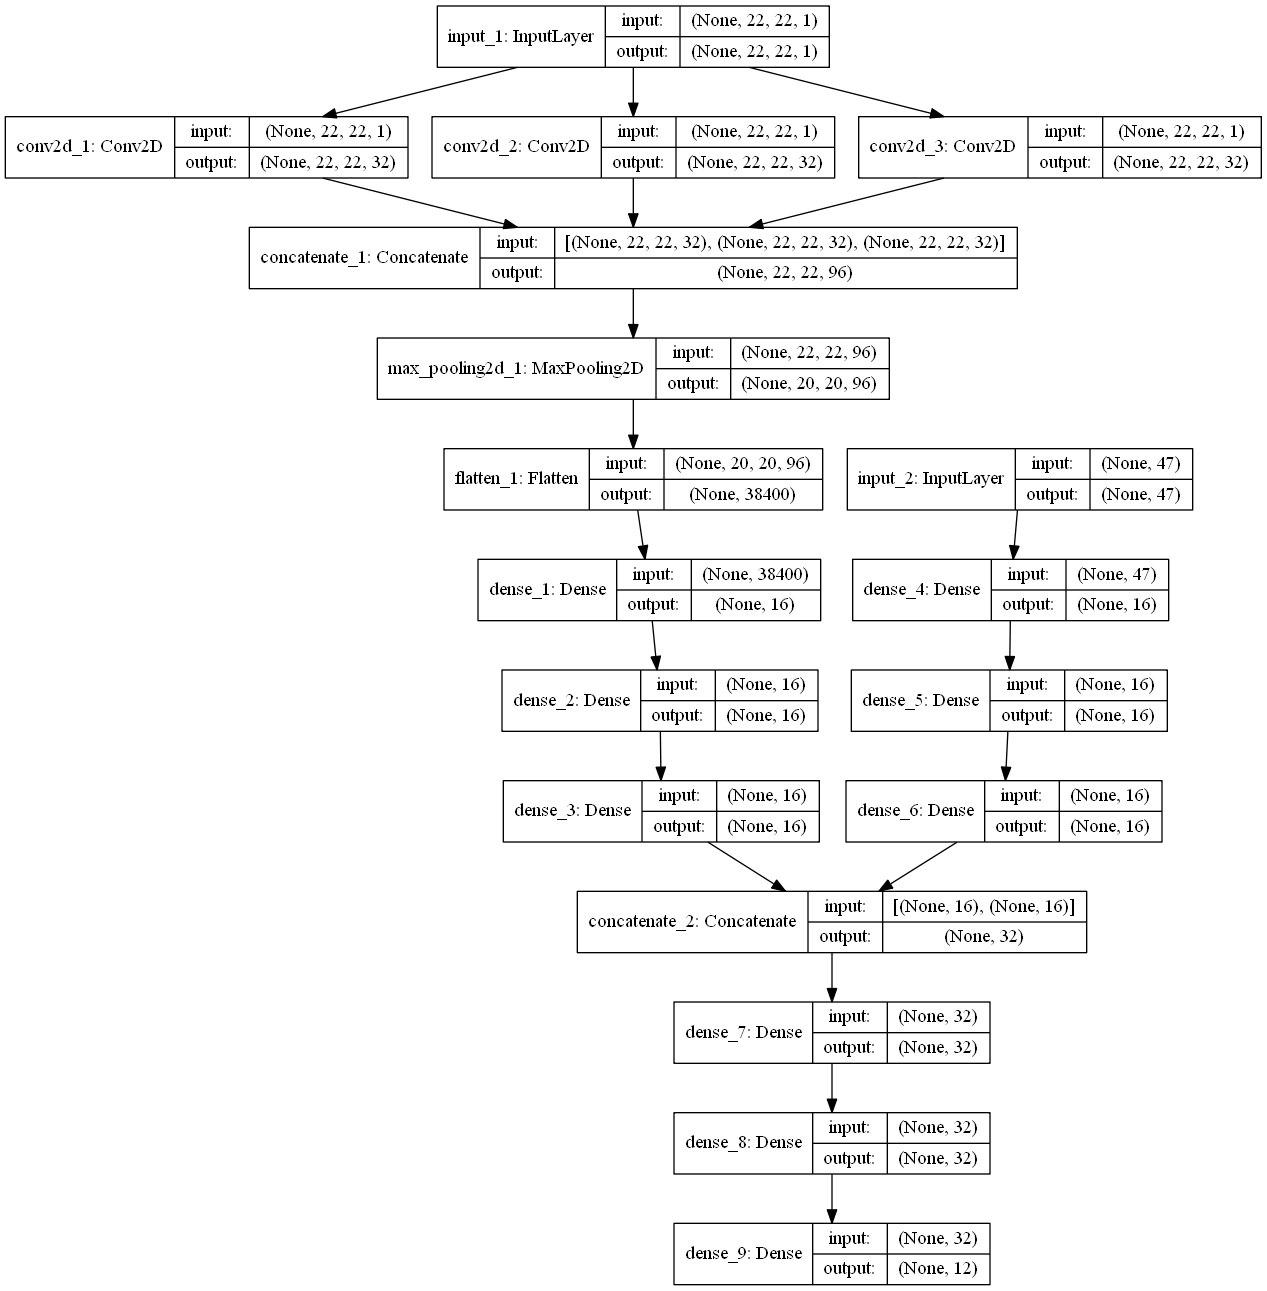

In [7]:
#agent.model.output
plot_model(agent.model, to_file='inception_with_info.png', show_shapes=True, show_layer_names=True)


In [8]:
fname = "simple_conv2d_model.hdf5"
agent.load(fname)

In [9]:
from ast import literal_eval

In [10]:
for i in range(1,10):
    
    csv_location = ".\\bu\\mawinw\\record\\Reinforce_Model_Episode_"+str(i)+".csv"
    file1 = open(csv_location, 'r') 
    Lines = file1.readlines() 

    count = 0
    # Strips the newline character 
    linecount = 0
    linestring = ""
    frames = []
    for line in Lines: 
        line = line.replace('\n', ' ').replace('\r', '')
        linestring += line
        linecount += 1
        if(linecount == 43):
            linecount = 0
            frames.append(linestring)
            linestring = ""
    file1.close()
    
    states = []
    next_states = []
    target_fs = []
    for frame in frames:
        state, state_info, action, reward, next_state,next_state_info, done = frame.split('|')
        state = np.array(literal_eval(state), dtype="float").reshape(22,22,1)
        next_state = np.array(literal_eval(next_state), dtype="float").reshape(22,22,1)
        states.append(state)
        next_states.append(next_state)
        target = reward
        if not done:
            target = reward + agent.gamma * np.amax(agent.model.predict(next_state)[0])
        target_f = agent.model.predict(np.array([state]))
        target_f[0][int(action)] = target
        target_fs.append(target_f[0])
    
    states = np.array(states)
    target_fs = np.array(target_fs)
    agent.model.fit(states, target_fs, epochs=2, verbose=2, batch_size=32)

Epoch 1/2
 - 7s - loss: 211.7046
Epoch 2/2
 - 7s - loss: 209.1059


FileNotFoundError: [Errno 2] No such file or directory: '.\\bu\\mawinw\\record\\Reinforce_Model_Episode_2.csv'

In [8]:
agent.save_model_formatting('inception_with_info')

In [11]:
agent.model.input

[<tf.Tensor 'input_1:0' shape=(None, 22, 22, 1) dtype=float32>,
 <tf.Tensor 'input_2:0' shape=(None, 47) dtype=float32>]